In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', 
                             patience=3, verbose=1, 
                             factor=0.8, min_lr=1e-4)
%matplotlib inline


print("Tesorflow Version:", tf.__version__)
print("Keras Version:",keras.__version__)

Tesorflow Version: 1.14.0
Keras Version: 2.2.4-tf


# Caricamento e Pre-analisi dei dati

In [2]:
# Dataset predefinito offerto da keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'esempi di training')
print(x_test.shape[0], 'esempi di test')

60000 esempi di training
10000 esempi di test


In [3]:
# Aggiunta dimensione canali
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print("(length, height, width, channel):",x_train.shape)

(length, height, width, channel): (60000, 28, 28, 1)


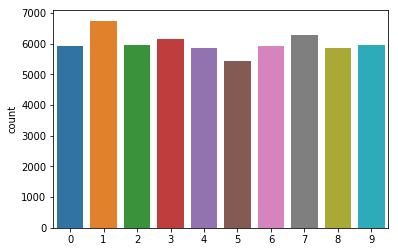

In [4]:
#controllo se le classi sono bilanciate
sns.countplot(y_train)
plt.show()

In [5]:
# Conversione di tipo
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Conversione in forma categorica
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train.shape

(60000, 10)

# Creazione e allenamento del modello
## Main assignment Problem

* Convoluzione bidimensionale con 32 filtri 3$\times$3
* ReLU
* Max pooling bidimensionale con filtro 2$\times$2
* Flattening
* Fully-connected che mappi a 128 dimensioni
* ReLU
* Fully-connected che mappi alla dimensione finale del problema

Si aggiunge SoftMax al layer finale visto che è un problema di multi-classificazione

La loss usata è il categorical crossentropy con ottimizzatore Adadelta con un learning rate di 0.05 che è stato calcolato con trial and error method.

In [7]:
model = Sequential()

#Convoluzione con 32 filtri 3x3 + ReLu
model.add(Conv2D(filters=32, kernel_size=(3,3),
                activation='relu', input_shape=(28, 28, 1)))

#Max Pooling con filtri 2x2
model.add(MaxPool2D(pool_size=(2,2)))

#Flattening
model.add(Flatten())

#FC che mappa a 128 dimensioni  + ReLu
model.add(Dense(128, activation='relu'))
#FC che mappa alla dimensione finale del problema (i.e. num_classes=10) + Softmax
model.add(Dense(num_classes, activation='softmax'))

#loss:categorical_crossentropy, optimizer:Adadelta, metrica da seguire per rendere
#più capibile all'umano l'andamento dell'allenamento
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.05),
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


Salviamo nella variabile history tutti le informazioni derivanti dal model.fit, i.e. i loss e accuracy per train e validation,
che poi saranno utili per il plot.

Mettiamo il numero di epoche a 50 con un lr_decay in cui il learning rate diminuisce nel caso di un aumento di validation loss per più di 3 volte successivamente e early (Early Stopping) con il quale l'allenamento si ferma se non vi è nessun miglioramento nel validation loss per 10 epoche.

Il batch size è stato scelto a 256.

In [9]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_decay, early])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 195us/sample - loss: 1.1191 - acc: 0.7398 - val_loss: 0.4317 - val_acc: 0.8864
Epoch 2/50
60000/60000 [==============================] - 10s 165us/sample - loss: 0.3754 - acc: 0.8952 - val_loss: 0.3226 - val_acc: 0.9088
Epoch 3/50
60000/60000 [==============================] - 10s 164us/sample - loss: 0.3108 - acc: 0.9097 - val_loss: 0.2779 - val_acc: 0.9202
Epoch 4/50
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2776 - acc: 0.9193 - val_loss: 0.2506 - val_acc: 0.9270
Epoch 5/50
60000/60000 [==============================] - 10s 167us/sample - loss: 0.2530 - acc: 0.9269 - val_loss: 0.2289 - val_acc: 0.9362
Epoch 6/50
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2330 - acc: 0.9330 - val_loss: 0.2121 - val_acc: 0.9398
Epoch 7/50
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2159 - acc: 0.9381 

In [91]:
print("Evaluation in Test set: \t [loss, accuracy] =", model.evaluate(x_test, y_test, verbose=0))
print("Evaluation in Training set:\t [loss, accuracy] =",model.evaluate(x_train, y_train, verbose=0))

Evaluation in Test set: 	 [loss, accuracy] = [0.057863499512989074, 0.9823]
Evaluation in Training set:	 [loss, accuracy] = [0.043235524722685416, 0.9882]


In [87]:
print(classification_report(y_test.argmax(axis=1), 
                            model.predict(x_test).argmax(axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9759    0.9898    0.9828       980
           1     0.9903    0.9930    0.9916      1135
           2     0.9825    0.9787    0.9806      1032
           3     0.9775    0.9891    0.9833      1010
           4     0.9808    0.9888    0.9848       982
           5     0.9789    0.9888    0.9838       892
           6     0.9853    0.9791    0.9822       958
           7     0.9796    0.9815    0.9806      1028
           8     0.9884    0.9600    0.9740       974
           9     0.9830    0.9732    0.9781      1009

    accuracy                         0.9823     10000
   macro avg     0.9822    0.9822    0.9822     10000
weighted avg     0.9823    0.9823    0.9823     10000



# Visualizzazione Risultati

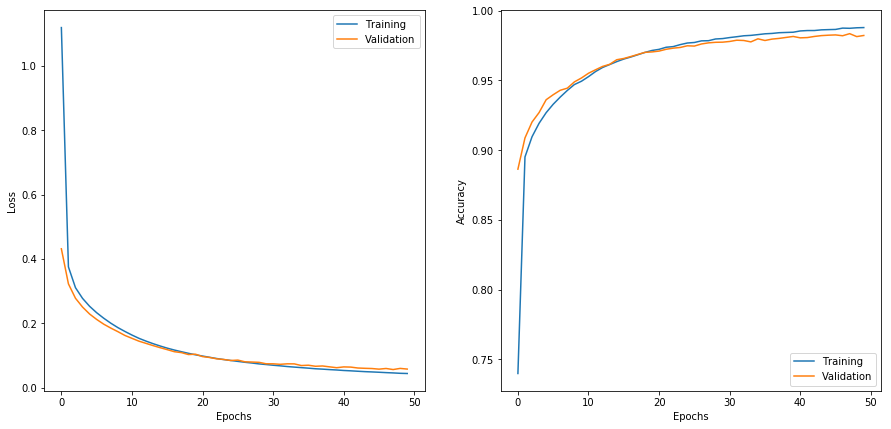

In [12]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training', 'Validation'])

ax2 = plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Nel plot sopra possiamo vedere che dopo un certo punto il modello migliora molto più il training che il validation set, non può essere completamente considerato un overfitting visto che lo stacco non è così grande (sono diversi solo nella terza cifra decimale).

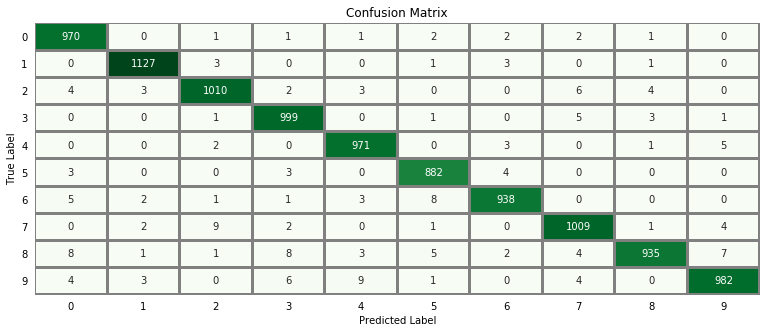

In [13]:
plt.figure(figsize = (13,5))
cf_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
ax = sns.heatmap(cf_matrix, cmap='Greens',
                 cbar=False, annot=True, fmt='d', linewidths=2, linecolor='gray')
ax.tick_params(left=False, bottom=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.show()

Nella matrice di confusione possiamo vedere dove sbaglia il modello e possiamo anche trarre delle conclusione da un punto di vista umano ad esempio il modello ha confuso diverse volte il 4 con il 9, e ciò può essere dovuto al fatto che si scrivono un maniera molto simile (avvolte se scritto un po' male confonde anche gli umani), un'altra cifra è il 2 con il 7.

Mostriamo con t-SNE la proeizione dell'ultimo layer in uno spazio bi-dimensionale, per fare ciò passeremo attraverso una PCA per ridurre le dimensione da 128 a 20 e poi verrà fatto una t-SNE da 20 dimensioni a 2, ciò è necessario perché t-SNE non si adatta bene a dimensioni grandi di suo.

La t-SNE è utile per capire quanto e come ha appreso il modello ad esempio si riescono a vedere i cluster di cifre che si formano, il colore è dovuto al y_test vero, e ciò aiuta anche a capire (come anche nella matrice di confusione) le cifre che il modello potrebbe confondere (non è detto che li confonda solo perché si trovano nello stesso cluster visto che abbiamo ridotto la dimensione).

In [68]:
#TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from tensorflow.keras.models import Model
tsne_model = Model(model.input, model.layers[-2].output) 
hidden_features = tsne_model.predict(x_test)

In [71]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

random_index = np.random.randint(0,9999,3333) #3333 elementi a caso ~ 1/3 dei dati
#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[random_index])

Variance PCA: 0.9055474996566772
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3333 samples in 0.003s...
[t-SNE] Computed neighbors for 3333 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3333
[t-SNE] Computed conditional probabilities for sample 2000 / 3333
[t-SNE] Computed conditional probabilities for sample 3000 / 3333
[t-SNE] Computed conditional probabilities for sample 3333 / 3333
[t-SNE] Mean sigma: 4.372934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.265808
[t-SNE] KL divergence after 1000 iterations: 1.024133


In [74]:
df_subset = pd.DataFrame()
color_map = np.argmax(y_test[random_index], axis=1)

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['number'] = color_map

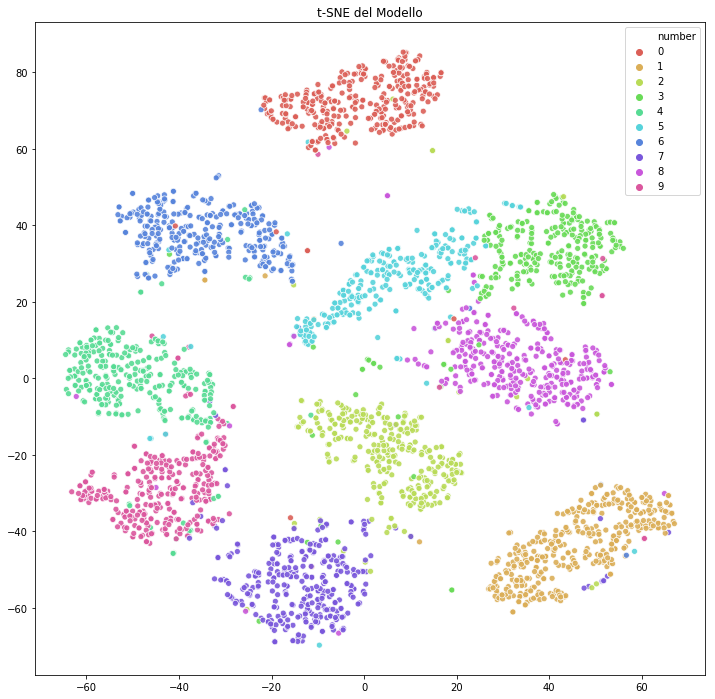

In [76]:
plt.figure(figsize=(12,12))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="number",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.9
)

plt.xlabel('')
plt.ylabel('')
plt.title('t-SNE del Modello')
plt.show()